In [43]:
import pyodbc as database
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [56]:
conn = database.connect(
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=DWH;"
    "Database=dwOper;"
    "Trusted_Connection=yes;")

In [57]:
query = f"""
SELECT PartnerUserId                                             AS TOTOID,
       CAST(RegistrationDate AS DATE)                            AS RegistrationDate,
       DATEDIFF(DAY,CAST(RegistrationDate AS DATE), GETDATE())   AS DaysRegistered,
       DATEDIFF(MONTH,CAST(RegistrationDate AS DATE), GETDATE()) AS MonthsRegistered,
       SUM(p.Amount)                                             AS DepositAmount,
       COUNT(p.PaymentID)                                        AS DepositCount
FROM VIEW_PlatformPartnerUsers_TotogamingAm u
    INNER JOIN Payment p on u.UserID = p.UserID
    INNER JOIN C_PaymentSystem ps on p.PaymentSystemID = ps.PaymentSystemId
WHERE p.PaymentTypeID = 2
  AND p.PaymentStatusID = 8
  AND ps.PaymentSystemName NOT IN ('PokerTransfer', 'TRANSFER')
  AND u.PartnerID = 237
  AND p.SourceID = 2
GROUP BY PartnerUserId,
         CAST(RegistrationDate AS DATE)

UNION

SELECT PartnerUserId                                             AS TOTOID,
       CAST(RegistrationDate AS DATE)                            AS RegistrationDate,
       DATEDIFF(DAY,CAST(RegistrationDate AS DATE), GETDATE())   AS DaysRegistered,
       DATEDIFF(MONTH,CAST(RegistrationDate AS DATE), GETDATE()) AS MonthsRegistered,
       SUM(p.Amount)                                             AS DepositAmount,
       COUNT(p.PaymentID)                                        AS DepositCount
FROM VIEW_sport_PartnerUser_TotogamingAm u
    INNER JOIN Payment p on u.UserID = p.UserID
    INNER JOIN C_PaymentSystem ps on p.PaymentSystemID = ps.PaymentSystemId
WHERE p.PaymentTypeID = 2
  AND p.PaymentStatusID = 8
  AND ps.PaymentSystemName NOT IN ('PokerTransfer', 'TRANSFER')
  AND u.PartnerID = 237
  AND p.SourceID = 2
GROUP BY PartnerUserId,
         CAST(RegistrationDate AS DATE)
"""

In [58]:
deposit_data = pd.read_sql(query, conn, parse_dates='RegistrationDate')
conn.close()

In [59]:
deposit_data.head()

,TOTOID,RegistrationDate,DaysRegistered,MonthsRegistered,DepositAmount,DepositCount
0,101185665,2022-02-15,358,12,83300.00000,112
1,100739577,2020-01-28,1107,37,1781100.00000,583
2,101113464,2021-07-01,587,19,2852339.00000,796
3,100384158,2016-05-30,2445,81,1740210.00000,155
4,101146255,2021-11-05,460,15,1100.00000,5


In [60]:
deposit_data.set_index("TOTOID", inplace=True)

In [61]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [62]:
deposit_data.describe()

,DaysRegistered,MonthsRegistered,DepositAmount,DepositCount
count,344176.00000,344176.00000,344176.00000,344176.00000
mean,1109.48529,36.67103,1127243.59905,194.83926
std,698.34812,22.94578,11380630.19229,520.61309
min,1.00000,0.00000,1.00000,1.00000
25%,585.00000,19.00000,5300.00000,5.00000
50%,983.00000,33.00000,46800.00000,31.00000
75%,1582.00000,52.00000,361934.25000,166.00000
max,6088.00000,200.00000,3363755596.00000,39471.00000


In [63]:
deposit_data['DailyAverageAmount'] = deposit_data['DepositAmount']/deposit_data['DaysRegistered']
deposit_data['DailyAverageCount']  = deposit_data['DepositCount'] /deposit_data['DaysRegistered']

In [64]:
deposit_data.describe()

,DaysRegistered,MonthsRegistered,DepositAmount,DepositCount,DailyAverageAmount,DailyAverageCount
count,344176.00000,344176.00000,344176.00000,344176.00000,344176.00000,344176.00000
mean,1109.48529,36.67103,1127243.59905,194.83926,1135.54027,0.21520
std,698.34812,22.94578,11380630.19229,520.61309,10187.05284,0.52315
min,1.00000,0.00000,1.00000,1.00000,0.00052,0.00016
25%,585.00000,19.00000,5300.00000,5.00000,6.35537,0.00577
50%,983.00000,33.00000,46800.00000,31.00000,63.40386,0.04294
75%,1582.00000,52.00000,361934.25000,166.00000,448.41087,0.20900
max,6088.00000,200.00000,3363755596.00000,39471.00000,1916000.00000,38.46465


In [65]:
df = deposit_data[['DailyAverageAmount', 'DailyAverageCount']]

In [67]:
df.describe()

,DailyAverageAmount,DailyAverageCount
count,344176.00000,344176.00000
mean,1135.54027,0.21520
std,10187.05284,0.52315
min,0.00052,0.00016
25%,6.35537,0.00577
50%,63.40386,0.04294
75%,448.41087,0.20900
max,1916000.00000,38.46465


In [68]:
def remove_outlier_IQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    return df_final

In [69]:
df_2 = df.copy()

In [70]:
df_2 = remove_outlier_IQR(df_2)

In [72]:
df_2.describe()

,DailyAverageAmount,DailyAverageCount
count,293849.00000,304228.00000
mean,153.57954,0.08660
std,242.76590,0.11981
min,0.00052,0.00016
25%,4.27350,0.00435
50%,34.54689,0.02857
75%,190.66129,0.12276
max,1111.47393,0.51385


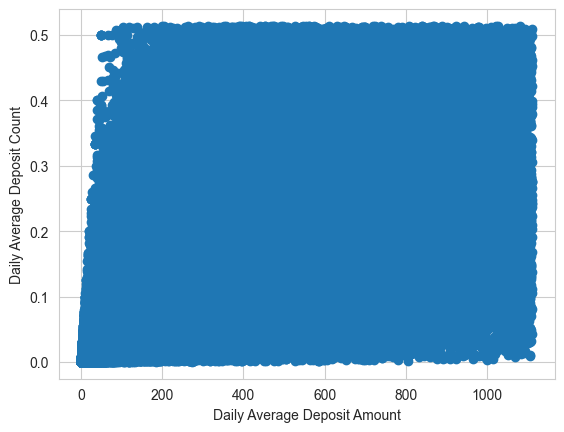

In [85]:
plt.scatter(df_2['DailyAverageAmount'], df_2['DailyAverageCount'])
plt.xlabel("Daily Average Deposit Amount")
plt.ylabel("Daily Average Deposit Count")
plt.show()

In [79]:
df_2.dropna(inplace=True)

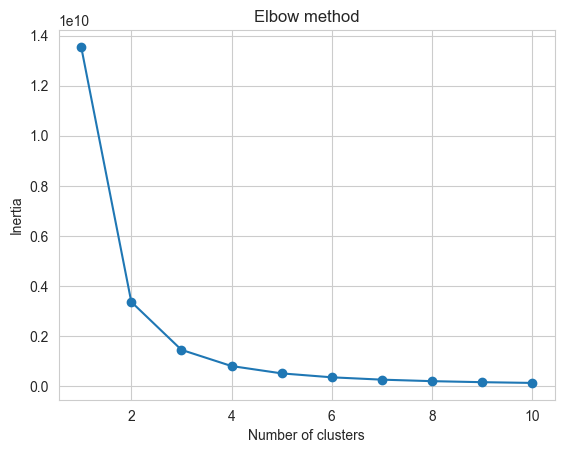

In [82]:
from sklearn.cluster import KMeans
x=df_2['DailyAverageAmount']
y=df_2['DailyAverageCount']
data = list(zip(x, y))
inertias = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

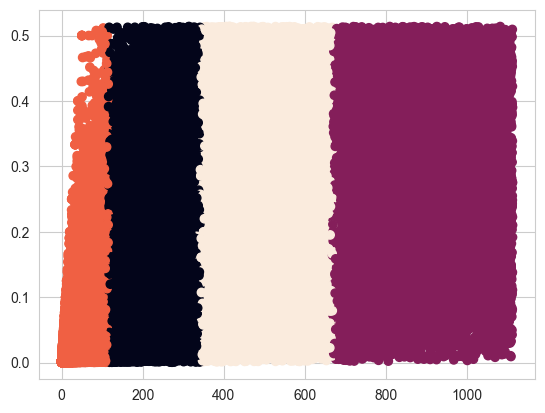

In [86]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(data)

plt.scatter(x, y, c=kmeans.labels_)
plt.show()

In [88]:
x = df_2.loc[:, ['DailyAverageAmount', 'DailyAverageCount']].values

In [89]:
from sklearn.neighbors import NearestNeighbors
neighb = NearestNeighbors(n_neighbors=2) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(x) # fitting the data to the object
distances,indices=nbrs.kneighbors(x)

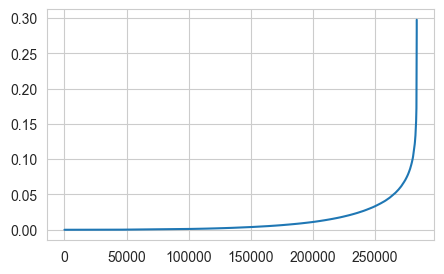

In [90]:
# Sort and plot the distances results
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot

In [93]:
from sklearn.cluster import DBSCAN
# cluster the data into five clusters
dbscan = DBSCAN(eps = 4, min_samples = 4).fit(x) # fitting the model
labels = dbscan.labels_ # getting the labels

MemoryError: 

ValueError: 'c' argument has 10 elements, which is inconsistent with 'x' and 'y' with size 283682.

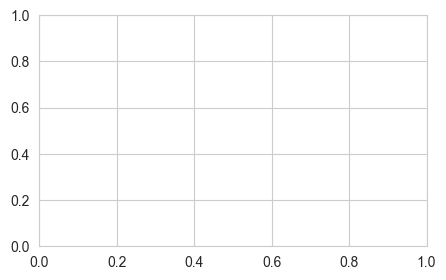

In [92]:
# Plot the clusters
plt.scatter(x[:, 0], x[:,1], c = labels, cmap= "plasma") # plotting the clusters
plt.xlabel("Income") # X-axis label
plt.ylabel("Spending Score") # Y-axis label
plt.show() # showing the plot

In [94]:
df_2.to_excel('tocolab.xlsx')